In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering


Book-Crossings dataset

Found here: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

Collected by Cai-Nicolas Ziegler in 2004. 278,858 users, 271,379 books, and 1,149,780 ratings.

This data was used in a publication:

Improving Recommendation Lists Through Topic Diversification,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.

In [2]:
## Loading the Data from Book-Crossings

df_books = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_users = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")

df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_users.rename(columns={'User-ID': 'User'}, inplace=True)
df_books.rename(columns={'ISBN': 'ISBN', 'Book-Title': 'Title', 'Year-Of-Publication': 'Year', 'Book-Author': 'Author'}, inplace=True)
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], 1, inplace=True)

# Using only explicit ratings. 0 ratings are 'implicit' in documentation of data:
df_ratings = df_ratings[df_ratings['Rating'] > 0]

# Inner join df_ratings and df_books
df_ratings = df_ratings[df_ratings['ISBN'].isin(df_books.ISBN.unique())]
df_books = df_books[df_books['ISBN'].isin(df_ratings.ISBN.unique())]

df_books.reset_index(inplace=True, drop=True)
df_ratings.reset_index(inplace=True, drop=True)
df_users.reset_index(inplace=True, drop=True)

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:30

In [4]:
# Change year column to int
df_books = df_books[df_books['Year'].apply(lambda x: isinstance(x, int))]
df_books.reset_index(drop=True, inplace=True)

avg_rating = []
num_ratings = []
for user in df_users.User:
    try:
        avg_rating.append(np.mean(df_ratings.Rating[df_ratings.User == user]))
    except:
        avg_ratings.append(None)
    num_ratings.append(len(df_ratings[df_ratings.User == user]))
df_users['AverageRating'] = avg_rating
df_users['NumberRatings'] = num_ratings

df_users = df_users[df_users.NumberRatings > 0]

In [105]:
### Books

In [106]:
df_books.head()

,ISBN,Title,Author,Year,Publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
3,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group


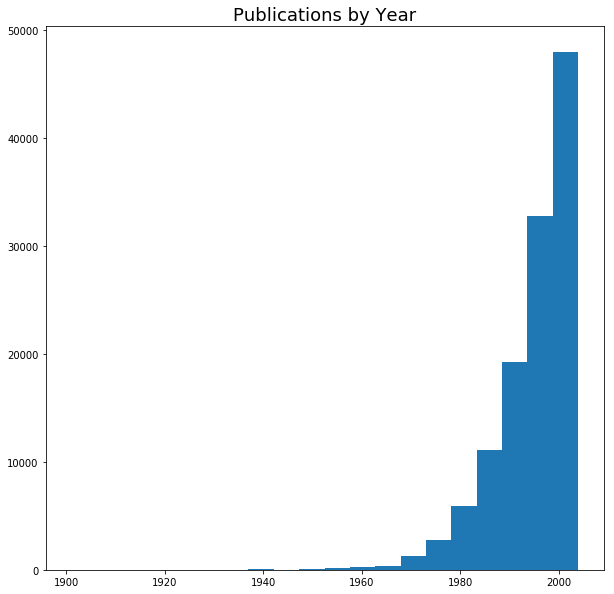

In [108]:
plt.figure(figsize=(10,10))
plt.hist(df_books['Year'][(df_books['Year'] > 1900) & (df_books['Year'] < 2005)], bins=20)
plt.title('Publications by Year', fontsize=18)
plt.show()

In [109]:
print('Unique Authors:', len(df_books.Author.unique()))
print('Unique Publishers:', len(df_books.Publisher.unique()))

Unique Authors: 50939
Unique Publishers: 9745


In [111]:
print('Number of books with publication year of 0:', len(df_books[df_books.Year == 0]))

Number of books with publication year of 0: 2238


In [89]:
max_pub, max_aut = 0, 0
pub, aut = '', ''
for author in df_books.Author.unique():
    if len(df_books[df_books.Author == author]) > max_aut:
        max_aut = len(df_books[df_books.Author == author])
        aut = author
print('Most prolific author:', aut, 'with {} books'.format(max_aut))
for publisher in df_books.Publisher.unique():
    if len(df_books[df_books.Publisher == publisher]) > max_pub:
        max_pub = len(df_books[df_books.Publisher == publisher])
        pub = publisher
print('Publisher with most publications:', pub, 'with {} books'.format(max_pub))


Most prolific author: Stephen King with 420 books
Publisher with most publications: Harlequin with 2726 books


In [ ]:
## Udsers

In [120]:
# Split location into city, region, and country
# Location is clearly self-reported so this is messy
city, region, country = [], [], []
for row in range(len(df_users)):
    split = df_users.Location.iloc[row].split(',')
    try:
        city.append(split[0])
    except:
        city.append(None)
    try:
        region.append(split[1])
    except:
        region.append(None)
    try:
        country.append(split[2])
    except:
        country.append(None)
df_users['City'] = city
df_users['Region'] = region
df_users['Country'] = country

In [121]:
df_users

,User,Location,Age,AverageRating,NumberRatings,City,Region,Country
7,8,"timmins, ontario, canada",NaN,5.571429,7,timmins,ontario,canada
8,9,"germantown, tennessee, usa",NaN,6.000000,1,germantown,tennessee,usa
11,12,"fort bragg, california, usa",NaN,10.000000,1,fort bragg,california,usa
13,14,"mediapolis, iowa, usa",NaN,5.333333,3,mediapolis,iowa,usa
15,16,"albuquerque, new mexico, usa",NaN,9.000000,1,albuquerque,new mexico,usa
16,17,"chesapeake, virginia, usa",NaN,5.250000,4,chesapeake,virginia,usa
18,19,"weston, ,",14.0,7.000000,1,weston,,
21,22,"erfurt, thueringen, germany",NaN,7.000000,1,erfurt,thueringen,germany
25,26,"bellevue, washington, usa",NaN,9.500000,2,bellevue,washington,usa
31,32,"portland, oregon, usa",NaN,8.000000,1,portland,oregon,usa


In [122]:
print('Unique cities:', len(df_users.City.unique()))
print('Unique regions:', len(df_users.Region.unique()))
print('Unique countries:', len(df_users.Country.unique()))

Unique cities: 12272
Unique regions: 1609
Unique countries: 347


In [52]:
size_dict = {}
reverse_dict = {}
for country in df_users.Country.unique():
    size_dict[country] = len(df_users[df_users.Country == country])
    reverse_dict[len(df_users[df_users.Country == country])] = country
sorted_values = sorted(size_dict.values(), reverse=True)

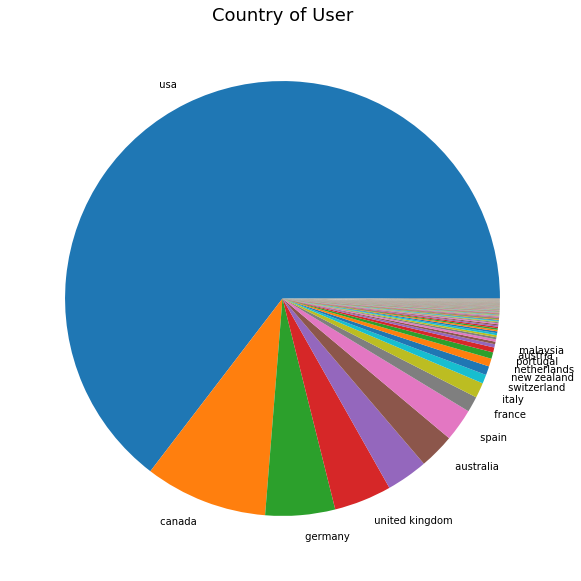

In [53]:
labels, sizes = [], []
i = 0
for size in sorted_values:
    sizes.append(size)
    if i < 15:
        labels.append(reverse_dict[size])
    else:
        labels.append('')
    i += 1
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels)
plt.title('Country of User', fontsize=18)
plt.show()

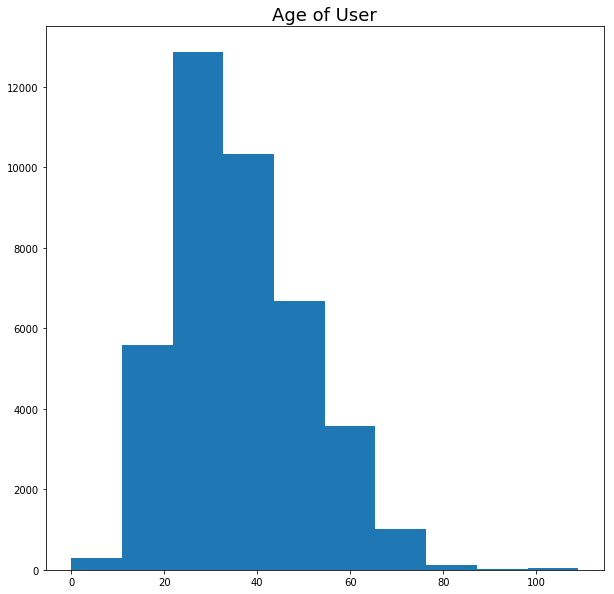

In [54]:
plt.figure(figsize=(10,10))
plt.hist(df_users.Age[df_users.Age < 110].dropna())
plt.title('Age of User', fontsize=18)
plt.show()

In [ ]:
## df_ratings

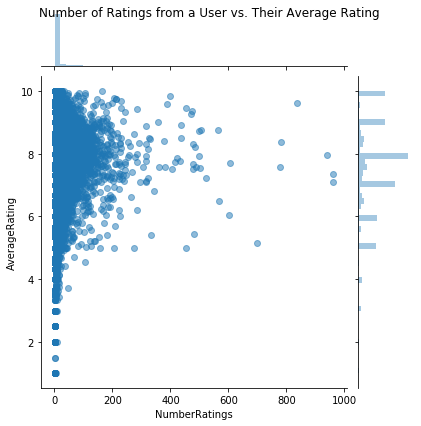

In [198]:
sns.jointplot('NumberRatings', 'AverageRating', df_users[(df_users.NumberRatings < 1000)], alpha=0.5, ratio = 5)
plt.suptitle('Number of Ratings from a User vs. Their Average Rating')
plt.show()

In [202]:
np.corrcoef(df_users[(df_users.NumberRatings < 1000)].NumberRatings, df_users[(df_users.NumberRatings < 1000)].AverageRating)

array([[1.        , 0.02106867],
       [0.02106867, 1.        ]])

In [ ]:
## df_ratings

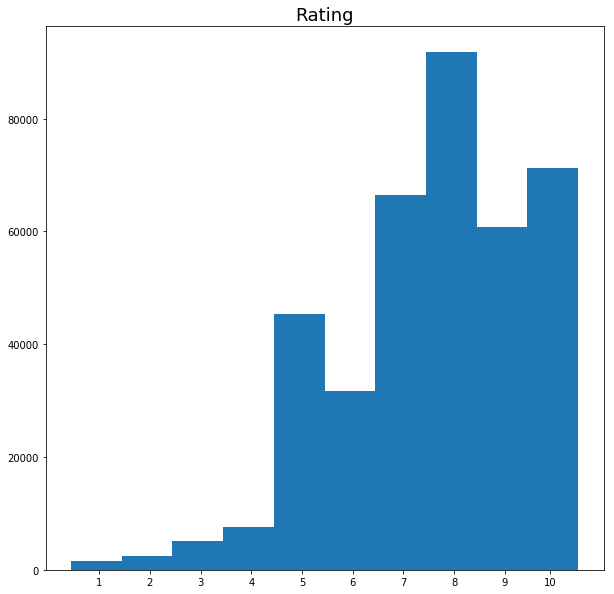

In [56]:
plt.figure(figsize=(10, 10))
plt.hist(df_ratings['Rating'][df_ratings['Rating'] > 0], bins=10)
plt.title('Rating', fontsize=18)
plt.xticks([1.5, 2.4, 3.3, 4.2, 5.1, 6, 6.9, 7.8, 8.7, 9.5], range(1,11))
plt.show()


In [58]:
print(np.mean(df_ratings['Rating'][df_ratings['Rating'] > 0]))
print(np.std(df_ratings['Rating'][df_ratings['Rating'] > 0]))


7.626700569505161
1.841336961660986


In [60]:
df_users.head()

,User,Location,Age,City,Region,Country,AverageRating,NumberRatings
7,8,"timmins, ontario, canada",NaN,timmins,ontario,canada,5.571429,7
8,9,"germantown, tennessee, usa",NaN,germantown,tennessee,usa,6.000000,1
11,12,"fort bragg, california, usa",NaN,fort bragg,california,usa,10.000000,1
13,14,"mediapolis, iowa, usa",NaN,mediapolis,iowa,usa,5.333333,3
15,16,"albuquerque, new mexico, usa",NaN,albuquerque,new mexico,usa,9.000000,1


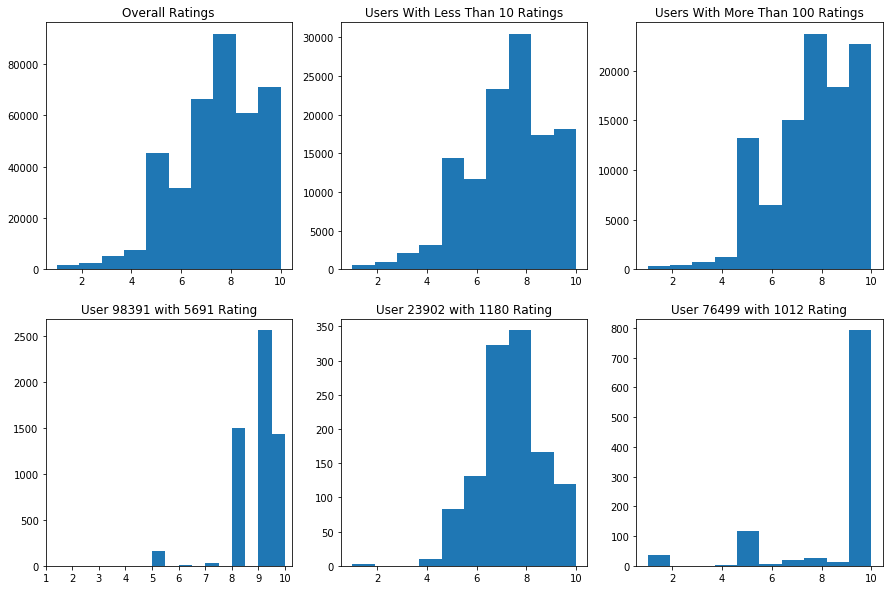

In [161]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].hist(df_ratings.Rating)
axes[0, 1].hist(df_ratings.Rating[df_ratings.User.isin(df_users.User[df_users.NumberRatings < 10])])
axes[0, 2].hist(df_ratings.Rating[df_ratings.User.isin(df_users.User[df_users.NumberRatings > 100])])
axes[1, 0].hist(df_ratings.Rating[df_ratings.User == 98391])
axes[1, 1].hist(df_ratings.Rating[df_ratings.User == 23902])
axes[1, 2].hist(df_ratings.Rating[df_ratings.User == 76499])

axes[1, 0].set_xticks(range(1, 11))

axes[0, 0].set_title('Overall Ratings')
axes[0, 1].set_title('Users With Less Than 10 Ratings')
axes[0, 2].set_title('Users With More Than 100 Ratings')
axes[1, 0].set_title('User 98391 with {} Rating'.format(len(df_ratings[df_ratings.User == 98391])))
axes[1, 1].set_title('User 23902 with {} Rating'.format(len(df_ratings[df_ratings.User == 23902])))
axes[1, 2].set_title('User 76499 with {} Rating'.format(len(df_ratings[df_ratings.User == 76499])))
plt.show()

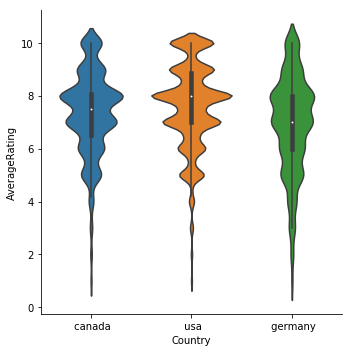

Canada mean: 7.36 	Canada standard deviation: 1.58
USA mean: 7.61 		USA standard deviation: 1.57
Germany mean: 6.94 	Germany standard deviation: 1.84


In [84]:
X = df_users[df_users.Country.isin([' usa', ' canada', ' germany'])]
sns.catplot(x="Country", y="AverageRating", data=X, kind='violin')
plt.show()
print('Canada mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' canada']), 2), '\tCanada standard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' canada']), 2))
print('USA mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' usa']), 2), '\t\tUSA standard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' usa']), 2))
print('Germany mean:', round(np.mean(df_users.AverageRating[df_users.Country == ' germany']), 2), '\tGermany standard deviation:', round(np.std(df_users.AverageRating[df_users.Country == ' germany']), 2))

In [177]:
df_users_cleaned = df_users.dropna()[(df_users.Age < 100) & (df_users.Age > 5)]
df_users_cleaned = df_users_cleaned[(df_users_cleaned.NumberRatings > 10) & (df_users_cleaned.NumberRatings < 1000)]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


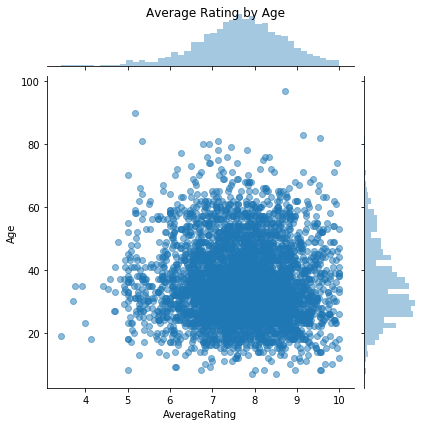

In [183]:
sns.jointplot('AverageRating', 'Age', data=df_users_cleaned, alpha = 0.5)
plt.suptitle('Average Rating by Age')
plt.show()

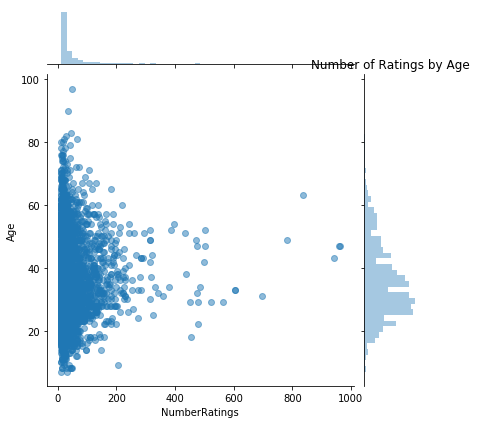

In [182]:
sns.jointplot('NumberRatings', 'Age', data=df_users_cleaned, alpha = 0.5)
plt.title('Number of Ratings by Age')
plt.show()

In [7]:
# Initial modeling using a baseline

benchmark = []
# Iterate over all algorithms
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df_ratings.sample(frac=0.1), reader)

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,1.722188,40.269502,0.997177
SVD,1.727052,4.385387,0.364046
BaselineOnly,1.740657,0.638788,0.449563
KNNBaseline,1.742142,27.415883,0.610865
KNNBasic,1.839890,28.323796,0.825473
KNNWithMeans,1.849682,21.387417,0.637516
SlopeOne,1.855036,66.064480,1.643247
KNNWithZScore,1.858132,24.074101,0.824237
CoClustering,1.944520,12.523522,0.318774


In [4]:
books_with_blurbs = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
books_with_blurbs.drop('Unnamed: 0', 1, inplace=True)
books_with_blurbs = books_with_blurbs.iloc[:, :6]

In [13]:
average_rating, number_ratings, popularity_score = [], [], []
global_mean_rating = np.mean(df_ratings.Rating)
for isbn in books_with_blurbs.ISBN:
    rating = np.mean(df_ratings.Rating[df_ratings.ISBN == isbn])
    number = len(df_ratings[df_ratings.ISBN == isbn])
    average_rating.append(rating)
    number_ratings.append(number)
    popularity_score.append(math.log(number) * (rating - global_mean_rating))
books_with_blurbs['AverageRating'] = average_rating
books_with_blurbs['NumberRatings'] = number_ratings
books_with_blurbs['PopularityScore'] = popularity_score

In [19]:
books_with_blurbs.to_csv('/DataScience/Final Capstone Files/books_with_popularities.csv', index=False)

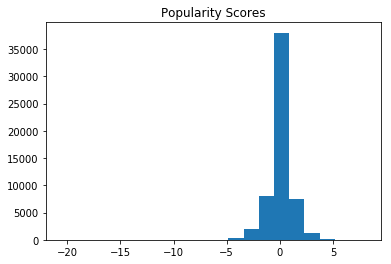

In [15]:
# The outlier is Wild Animus
plt.hist(books_with_blurbs.PopularityScore, bins=20)
plt.title('Popularity Scores')
plt.show()

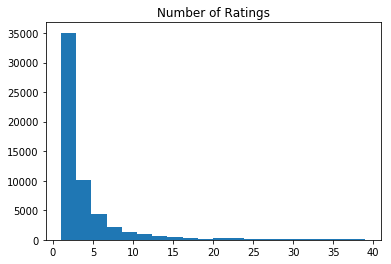

In [16]:
# Heavily right skewed. This is only less than 40 ratings, there are plenty of outliers to the right
plt.hist(books_with_blurbs.NumberRatings[books_with_blurbs.NumberRatings < 40], bins=20)
plt.title('Number of Ratings')
plt.show()

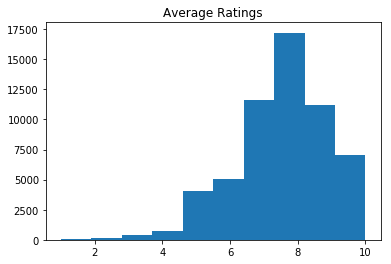

In [17]:
# Heavily right skewed. This is only less than 40 ratings, there are plenty of outliers to the right
plt.hist(books_with_blurbs.AverageRating, bins=10)
plt.title('Average Ratings')
plt.show()

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


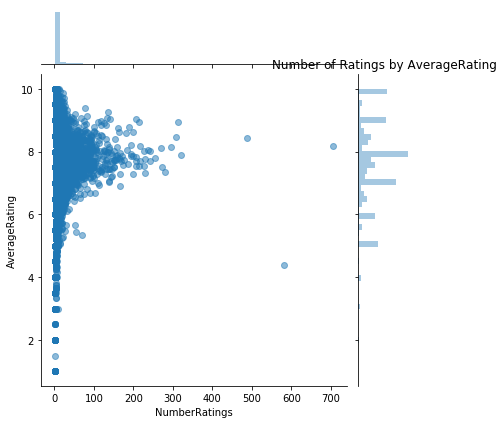

In [18]:
sns.jointplot('NumberRatings', 'AverageRating', data=books_with_blurbs, alpha = 0.5)
plt.title('Number of Ratings by AverageRating')
plt.show()

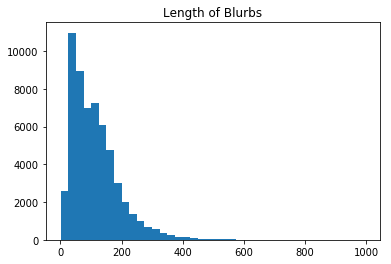

In [27]:
blurb_lengths = []
for blurb in books_with_blurbs.Blurb:
    leng = len(blurb.split())
    if leng < 1000:
        blurb_lengths.append(len(blurb.split()))
plt.hist(blurb_lengths, bins=40)
plt.title('Length of Blurbs')
plt.show()